setting up the framework to develop and backtest algorithms

## Basic strategies to implement

### Simple moving averages (SMA)
when the moving average over a longer period of time crosses the moving average over a shorter period of time, that's our indicator.

### momentum
recent performance been up in the last say 4 days then it'll probably be up today also

### mean reversion
if sotck is above/below the mean it'll probably revert and approach the mean/moving average


# Vectorized Implementation
we will make some predetermined simplifications so that i have more focus on the practice of vectorization

### simple trading strategies
vectorized backtesting has limitations when it comes to backtesting, however, simple strategies can be tested well

### interactive strategy exploration
this vectorized backtesting allows for us to quickly explore trading strategies and their characteristics, parameters can then also be swapped out

### visualization as a goal
this approach lends itself well to being able to create visualizations of the data we are working with

### also it's fast!

going to be based on two indices which track gold

In [12]:
import pandas as pd
import numpy as np

In [ ]:
raw = pd.read_csv("data/aiif_eikon_eod_data.csv", index_col=0, parse_dates=True).dropna()



In [19]:
data = pd.DataFrame(raw["GDX"])

In [20]:
data.rename(columns={"GDX": "price"}, inplace=True)
data['returns'] = np.log(data['price'] / data['price'].shift(1)) # returns = (today/yesterday)

In [21]:
SMA = 25

data['SMA'] = data['price'].rolling(SMA).mean()
data['SMA'] = data['SMA'].shift(1) # shift to avoid lookahead bias


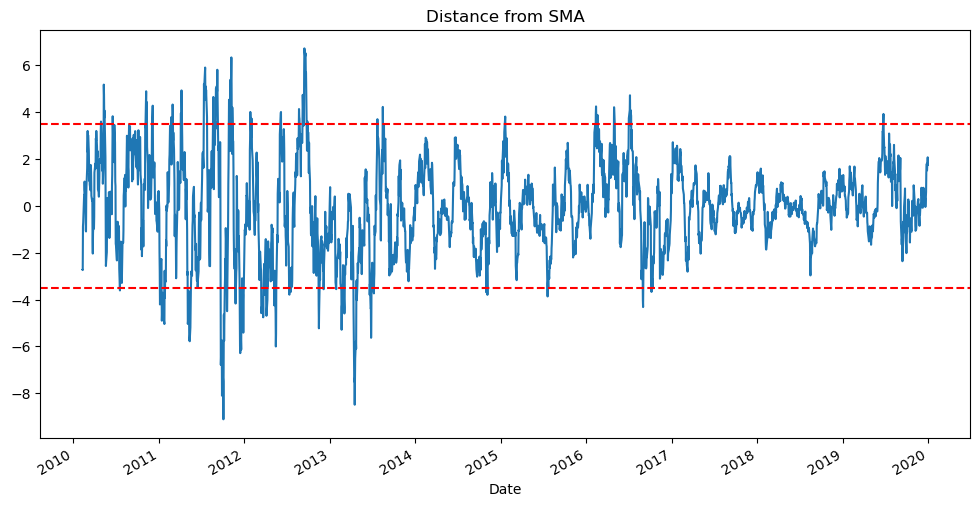

In [24]:
threshold = 3.5
data["distance"] = data["price"] - data["SMA"]


from pylab import plt, mpl
# plot distance with threshold
data["distance"].plot(title="Distance from SMA", figsize=(12, 6))
plt.axhline(threshold, color='red', linestyle='--')
plt.axhline(-threshold, color='red', linestyle='--')

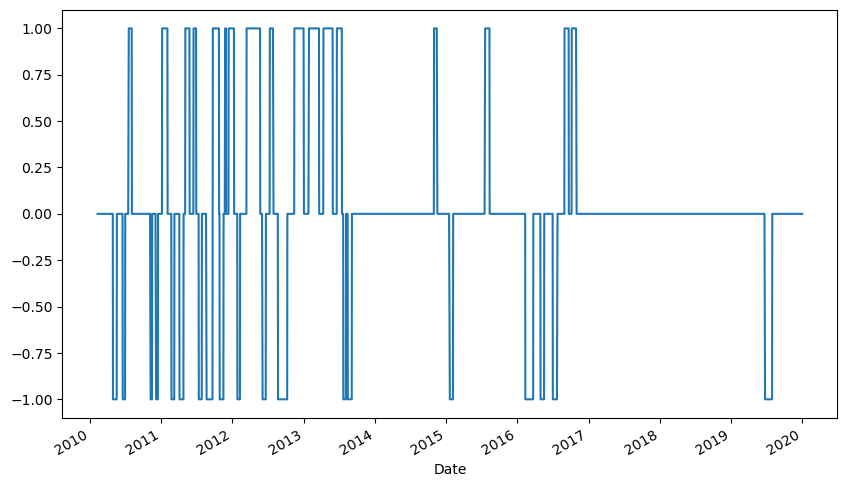

In [ ]:

# if the distance is greater than the threshold, we go short
data["position"] = np.where(data["distance"] > threshold, -1, np.nan)

# if the distance is less than the negative threshold, we go long
data["position"] = np.where(data['distance'] < -threshold, 1, data['position'])

# if there is a change in sign, go neutral
data['position'] = np.where(data['distance'] * data['distance'].shift(1) < 0, 0, data['position'])

# clean up
data['position'] = data['position'].ffill().fillna(0)

data['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1],figsize=(10, 6))

<Axes: xlabel='Date'>

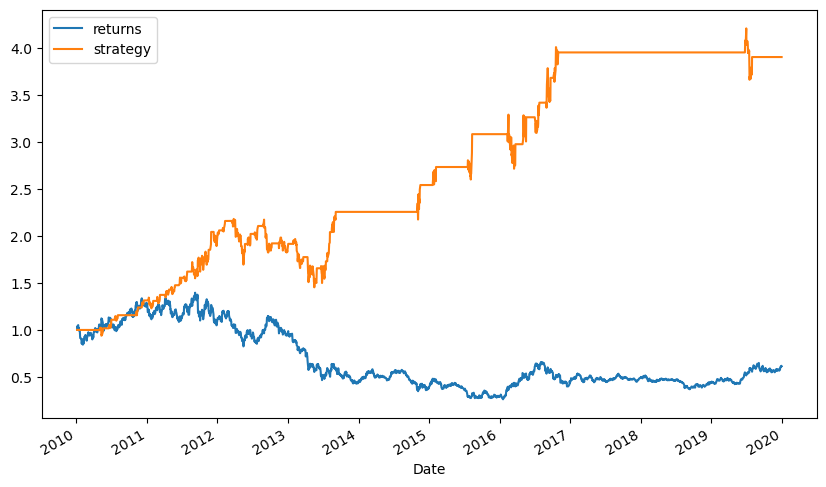

In [29]:
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))

In [33]:
import mean_reversion as mr

mrbt = mr.MRVectorBacktester("GLD",  '2010-1-1', '2019-12-31', 10000, 0.001)
mrbt.run_strategy(SMA=43, threshold=7.5)

/opt/notebooks/mean_reversion.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["strategy"][trades] -= self.tc


(13542.15, 646.21)

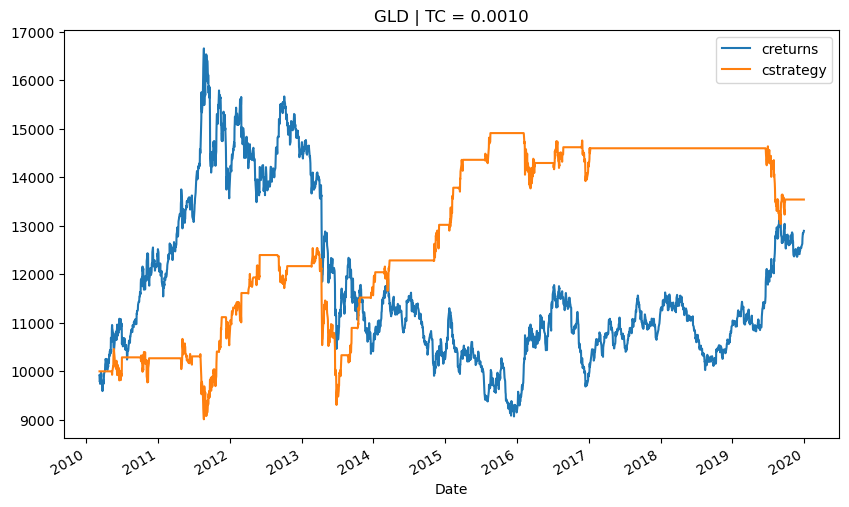

In [34]:
mrbt.plot_results()